**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Introducción al Aprendizaje profundo**

*Edición 2023*

----

# Trabajo práctico entregable

Dado el dataset que busca predecir la [presencia o ausencia de Diabetes](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset/data?select=diabetes_binary_5050split_health_indicators_BRFSS2015.csv).

## Ejercicio 3 - Implementar modelo con ajuste de hiperparámetros e interpretación de resultados

En una siguiente instancia realizar una búsqueda de hiperparámetros buscando mejorar el baseline.

Mostrar e interpretar los resultados.

----

### Imports y lectura de datasets

In [2]:
import tqdm
import torch

import numpy as np
import pandas as pd
import seaborn as sns

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt

In [3]:
# Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Lectura de Datasets

In [4]:
X = pd.read_csv('datasets/std_data.csv')
y = pd.read_csv('datasets/obj_data.csv')
X.shape, y.shape

((70692, 21), (70692, 1))

In [5]:
X.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.880201,-1.052798,0.159276,-0.542176,-0.951711,-0.257473,-0.41647,0.649925,-1.255371,0.517485,...,0.217175,-0.321945,0.146304,0.153020,2.404008,-0.581554,1.090046,-1.607237,1.048562,1.05816
1,0.880201,0.949850,0.159276,-0.542176,1.050740,3.883895,-0.41647,-1.538638,0.796577,-1.932424,...,0.217175,-0.321945,0.146304,-0.460058,-0.577451,-0.581554,1.090046,1.197681,1.048562,1.05816
2,-1.136104,-1.052798,0.159276,-0.542176,-0.951711,-0.257473,-0.41647,0.649925,0.796577,0.517485,...,0.217175,-0.321945,-1.649743,-0.460058,0.416369,-0.581554,1.090046,1.548296,1.048562,1.05816
3,0.880201,0.949850,0.159276,-0.261036,1.050740,-0.257473,-0.41647,0.649925,0.796577,0.517485,...,0.217175,-0.321945,0.146304,-0.460058,-0.279305,-0.581554,1.090046,0.847066,1.048562,1.05816
4,-1.136104,-1.052798,0.159276,-0.120466,1.050740,-0.257473,-0.41647,0.649925,0.796577,0.517485,...,0.217175,-0.321945,-0.751719,-0.460058,-0.577451,-0.581554,-0.917392,-0.204778,0.076814,1.05816


In [6]:
y.head()

,Diabetes_binary
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


### División del dataset

Dividimos aleatoriamente los datos en 80% para ***entrenamiento*** y 20% para ***test***.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    train_size=0.8, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56553, 21), (14139, 21), (56553, 1), (14139, 1))

Una vez separados los datasets, es necesario convertir los datos en ***tensores*** de *PyTorch*.

In [8]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

### Planteo de modelos

Se plantearán 3 redes neuronales con distintas arquitecturas. Una simple, con una capa oculta con el doble de neuronas que de entradas. Una mediana, con una capa oculta, pero el cuádruple de neuronas que de entradas. Y una última con 2 capas ocultas, pero con el mismo número de neuronas en cada capa, igual que en la capa de la primera red.

   1) Red Base.
   2) Red Mediana (Red Base con misma cantidad de capas ocultas pero más neuronas).
   3) Red Grande (Red Base con más capas ocultas, misma cantidad de neuronas).

In [9]:
# Modelo base
class SimpleMLP(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_hidden, activation_function):
        super().__init__()
        self.hidden_layer1 = nn.Linear(n_inputs, n_hidden)
        self.output_layer = nn.Linear(n_hidden, n_outputs)
        self.activation_function = activation_function

    def forward(self, x: torch.Tensor):
        x = self.hidden_layer1(x)  # Go through hidden layer 1
        x = self.activation_function(x)  # Activation Function layer 1
        x = self.output_layer(x)  # Output Layer
        return x

In [10]:
# Modelo mediano
class MediumMLP(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_hidden, activation_function):
        super().__init__()
        self.hidden_layer1 = nn.Linear(n_inputs, n_hidden*2)
        self.output_layer = nn.Linear(n_hidden*2, n_outputs)
        self.activation_function = activation_function

    def forward(self, x: torch.Tensor):
        x = self.hidden_layer1(x)  # Go through hidden layer 1
        x = self.activation_function(x)  # Activation Function layer 1
        x = self.output_layer(x)  # Output Layer
        return x

In [11]:
# Modelo complejo
class BigMLP(nn.Module):
    def __init__(self, n_inputs, n_outputs, n_hidden, activation_function):
        super().__init__()
        self.hidden_layer1 = nn.Linear(n_inputs, n_hidden)
        self.hidden_layer2 = nn.Linear(n_hidden, n_hidden)
        self.output_layer = nn.Linear(n_hidden, n_outputs)
        self.activation_function = activation_function

    def forward(self, x: torch.Tensor):
        x = self.activation_function(self.hidden_layer1(x))
        x = self.activation_function(self.hidden_layer2(x))
        x = self.output_layer(x)  # Output Layer
        return x

Una vez definidas las arquitecturas de los modelos, resta definir los parámetros con los que trabajará cada una de ellas.

In [12]:
# Parámetros
input_size = X_train.shape[1]  # Número de características
output_size = 1  # Salida binaria (diabetes sí/no)
# El tamaño de la capa oculta es una elección que puedes ajustar según sea necesario
hidden_size = 2 * input_size  # Número de neuronas en la capa oculta (ejemplo)

In [13]:
EPOCHS = 200

# Función de pérdida
loss_function = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss
# Esta función de pérdida no puede cambiar, 
# para que la salida tenga una salida binaria

# Usamos ReLU como función de activación
activation_function = nn.ReLU()

Instanciamos los modelos y entrenaremos usando sus hiperparámetros por defecto, así obtendremos un baseline de cada uno para luego comparar cuando obtenga los modelos optimizados.

In [14]:
models = [
    SimpleMLP(input_size, output_size, hidden_size, activation_function),
    MediumMLP(input_size, output_size, hidden_size, activation_function),
    BigMLP(input_size, output_size, hidden_size, activation_function)
]

### Entrenamiento de los modelos base

Definiremos funciones auxiliares que se utilizarán para el entrenamiento. 

In [15]:
def train(model, optimizer, loss_function, trainloader, epoch, use_tqdm=True):

    # Mueve el modelo a la GPU si está disponible
    model.to(device)
    # Activa el modo de entrenamiento
    model.train()

    # Inicializa la pérdida acumulada para la época actual
    training_loss = 0.0
    # Crea una barra de progreso utilizando tqdm si use_tqdm es True
    pbar = tqdm(trainloader) if use_tqdm else trainloader

    # Itera sobre los mini-batches del conjunto de entrenamiento
    for step, (inputs, labels) in enumerate(pbar, 1):
        # Mueve los tensores a la GPU si es necesario
        inputs, labels = inputs.to(device), labels.to(device)

        # Pone a cero los gradientes en el optimizador
        optimizer.zero_grad()
        # Realiza un pase hacia adelante (forward pass)
        predicted_outputs = model(inputs.view(inputs.shape[0], -1))
        # Calcula la pérdida
        loss = loss_function(predicted_outputs, labels)
        # Retropropagación
        # Calcula los gradientes
        loss.backward()

        # Acumula la pérdida promedio del mini-batch
        training_loss += loss.item()
        # Actualiza los parámetros del modelo usando el optimizador
        optimizer.step()

        # Imprime estadísticas cada 50 mini-batches si se utiliza tqdm
        if use_tqdm and step % 50 == 0:
            # Muestra el número de época, paso y pérdida promedio
            pbar.set_description(f"[{epoch}, {step}] loss: {training_loss / step:.4g}")

    # Calcula la pérdida promedio para la época y redondea a 4 decimales
    epoch_training_loss = round(training_loss / len(trainloader), 4)

    # Devuelve la pérdida promedio para la época
    return epoch_training_loss

In [16]:
def validation(model, valiloader, loss_function, prefix='test_', use_tqdm=True):

    # Mueve el modelo a la GPU si está disponible
    model.to(device)
    # Activa el modo de evaluación
    model.eval()

    # Listas para almacenar las etiquetas verdaderas y las predicciones
    y_true = []
    y_pred = []

    # Inicializa la pérdida de validación y la precisión en ejecución
    validation_loss = 0.0
    running_accuracy = 0.0
    total = 0

    # No calcula gradientes para acelerar el pase hacia adelante
    with torch.no_grad():

        # Crea una barra de progreso utilizando tqdm si use_tqdm es True
        pbar = tqdm(valiloader) if use_tqdm else valiloader

        for (inputs, labels) in pbar:
            # Mueve los tensores a la GPU si es necesario
            inputs, labels = inputs.to(device), labels.to(device)
            # Realiza un pase hacia adelante (forward pass)
            predicted_outputs = model(inputs.view(inputs.shape[0], -1))
            # Calcula la pérdida
            loss = loss_function(predicted_outputs, labels)
            # Acumula la pérdida promedio del mini-batch
            validation_loss += loss.item()

            # La etiqueta con el valor más alto será nuestra predicción
            _, predicted = torch.max(predicted_outputs, 1)
            # Extiende las listas de etiquetas verdaderas y predichas
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calcula la pérdida promedio para la validación y redondea a 4 decimales
    epoch_validation_loss = round(validation_loss / len(valiloader), 4)

    # Calcula métricas de evaluación (precisión y F1-score)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    f1 = round(metrics.f1_score(y_true, y_pred, average='macro'), 4)

    # Devuelve la pérdida promedio y las métricas de evaluación
    return epoch_validation_loss, (accuracy, f1)

In [17]:
def run_experiment(model, n_epochs, trainloader, valiloader, loss_function, optimizer):

    register_performance = {
        'epoch': [],
        'epoch_training_loss': [],
        'epoch_validation_loss': [],
        'validation_accuracy': [],
        'validation_f1': []
        }

    best_model = None
    best_accuracy = 0.0

    print("Begin training...")
    # Loop through the dataset multiple times
    for epoch in range(1, n_epochs + 1):
        # Train the model
        epoch_training_loss = train(model, optimizer, loss_function, trainloader, epoch)
        # Test the model
        epoch_validation_loss, metrics = validation(model, valiloader, loss_function)

        register_performance['epoch'].append(epoch)
        register_performance['epoch_training_loss'].append(epoch_training_loss)
        register_performance['epoch_validation_loss'].append(epoch_validation_loss)
        register_performance['validation_accuracy'].append(metrics[0])
        register_performance['validation_f1'].append(metrics[1])

        # Save the model if the accuracy is the best
        if metrics[0] > best_accuracy:
            best_model = model
            best_accuracy = metrics[0]

        # Print the statistics of the epoch
        print(f'Completed training in {epoch} batch: ',
            'Training Loss is: ' , epoch_training_loss,
            '- Validation Loss is: ', epoch_validation_loss,
            '- Accuracy is: ', (metrics[0]),
            '- F1 is: ', (metrics[1])
            )

    # Save the results
    experiment = {
        'arquitecture': model.__class__.__name__,
        'optimizer': optimizer,
        'loss': str(loss_function),
        'epochs': n_epochs,
    }

    return experiment, register_performance, best_model

In [18]:
def plot_loss(experiment, figsize):
    df_experiment = pd.DataFrame(experiment[1])
    # Configura el tamaño de la gráfica
    plt.figure(figsize=figsize)
    
    plt.title(label=experiment[0]['arquitecture'])
    ax = sns.pointplot(data=df_experiment, x='epoch', y='epoch_training_loss', color='orange', label='Training')
    ax = sns.pointplot(data=df_experiment, x='epoch', y='epoch_validation_loss', label='Validation')
    plt.ylabel('Loss')
    
    ax.set_xticks(ax.get_xticks()[::20])
    plt.legend()
    plt.show()

In [19]:
def get_data_loss_metrics(experiments_set):
    df_base = pd.DataFrame()
    for i in range(len(experiments_set)):
        arquitecture = experiments_set[i][0]['arquitecture']
        model_name = arquitecture.split('(')[0]
        activation_function_name = arquitecture.split('(')[-2].split(': ')[1]
        optim = type(experiments_set[i][0]['optimizer']).__name__
        lr = experiments_set[i][0]['optimizer'].param_groups[0]['lr']
        weight_decay = experiments_set[i][0]['optimizer'].param_groups[0]['weight_decay']
        df = pd.DataFrame(experiments_set[i][1])
        df['model-activation-optimizer-lr-wd'] = f'{model_name}-{activation_function_name}-{optim}-{lr}-{weight_decay}'
        df_base = pd.concat([df_base, df])

    df_metrics = df_base.drop(columns=['epoch_training_loss', 'epoch_validation_loss'])
    df_loss = df_base.drop(columns=['validation_accuracy', 'validation_f1']).melt(id_vars=['epoch', 'model-activation-optimizer-lr-wd'],
                                                                                        value_vars=['epoch_training_loss', 'epoch_validation_loss'],
                                                                                        var_name='task', value_name='loss')
    return df_loss, df_metrics

Antes de comenzar prepararemos los datos con los que entrenaremos y validaremos el modelo.

In [20]:
# Movemos los datos al device seleccionado
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [21]:
batch_size = 50
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
experiments = []

for model in models:
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    experiment = run_experiment(model, EPOCHS, train_loader, test_loader, loss_function, optimizer)
    experiments.append(experiment)

Analizaremos la función de pérdida de cada modelo a lo largo de las épocas.

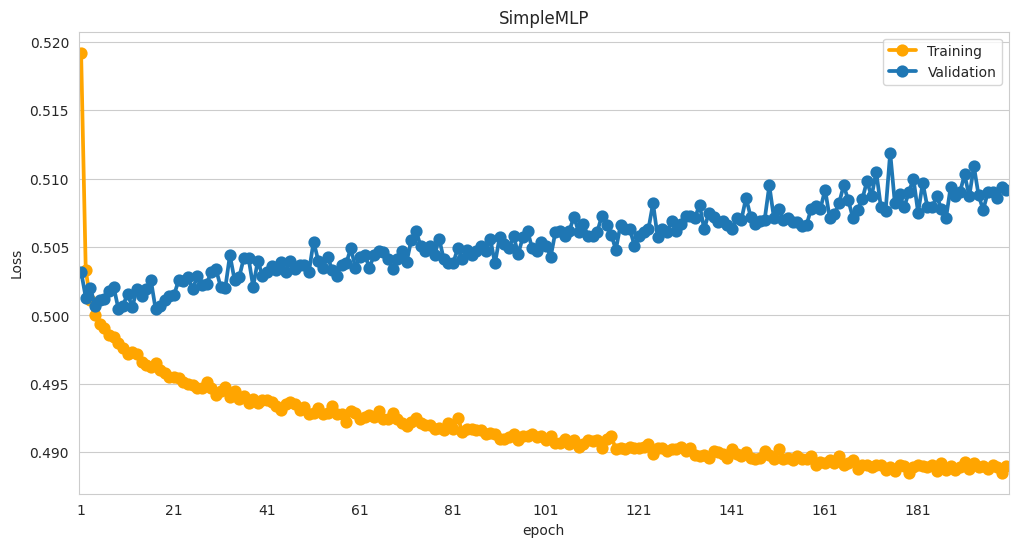

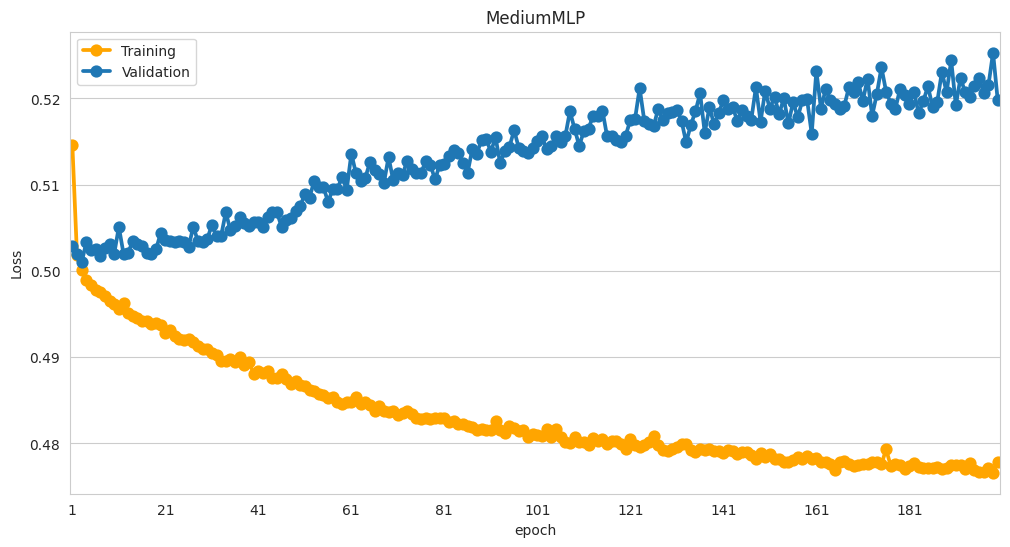

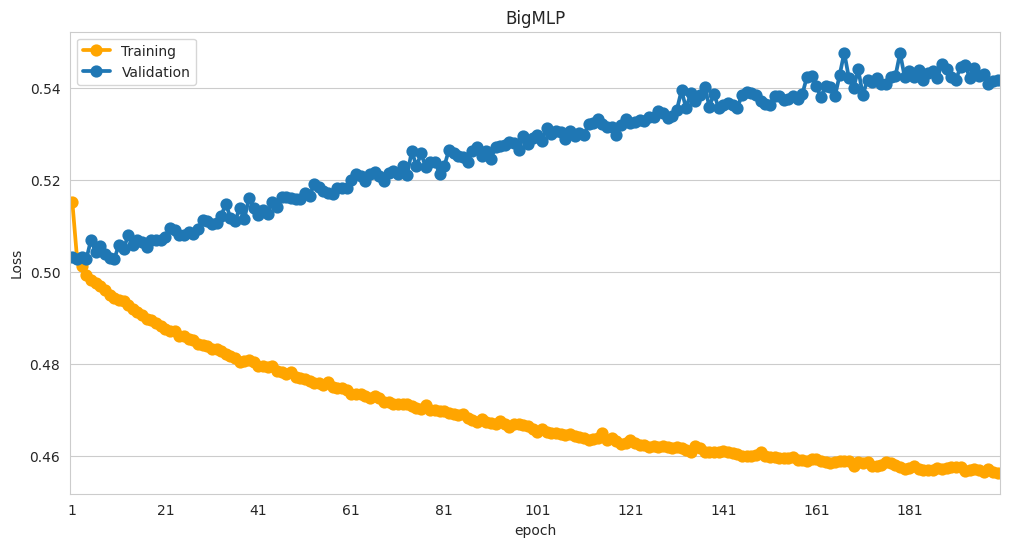

In [62]:
for experiment in experiments:
    plot_loss(experiment,(12, 6))

Observamos que la función *loss* para el set de ***entrenamiento*** disminuye a lo largo de las épocas, mientras que para el caso del conjunto de ***validación*** observamos que esta función tiene una tendencia alcista, que se acentúa más a medida que se complejiza el modelo. Por lo que se puede interpretar que los modelos no predicen bien las etiquetas a medida que se complejizan.

### Fine-tuning

Con el objetivo de mejorar el comportamiento de los modelos planteados, se realizará un ajuste de hiperparámetros.

In [45]:
activation_functions = {
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU()
}

optimizers = {
    'Adaptative Gradient Algorithm': optim.Adagrad,
    'Root Mean Square Propagation': optim.RMSprop,
    'Adaptive Moment Estimation': optim.Adam
}

learning_rates = [
    0.01,
    0.005,
    0.001
]

weight_decays = [
    0,
    0.001,
    0.1
]

In [ ]:
from itertools import product

# Guarda el mejor modelo y sus resultados
best_model = None
best_experiment = {}
best_performance = {}
best_metric_sum = 0.0

for model in models:
    # Itera sobre todas las combinaciones posibles de modelos y hiperparámetros
    for activation_function, optimizer, lr, weight_decay in product(activation_functions.values(), optimizers.values(), learning_rates, weight_decays):

        # Crea el modelo y el optimizador con los hiperparámetros actuales
        model.activation_function = activation_function
        current_optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)

        # Ejecuta el experimento
        experiment, performance, current_best_model = run_experiment(model, EPOCHS, train_loader, test_loader, loss_function, current_optimizer)

        # Calcula la suma de la precisión y F1 (puedes ajustar este criterio según tus necesidades)
        current_metric_sum = performance['validation_accuracy'][-1] + performance['validation_f1'][-1]

        # Actualiza el mejor modelo y resultados si es necesario
        if current_metric_sum > best_metric_sum:
            best_metric_sum = current_metric_sum
            best_model = current_best_model
            best_experiment = experiment
            best_performance = performance

In [49]:
# Imprime los resultados del mejor modelo
print("Best Model Architecture:", best_model)
print("Best Model Optimizer:", best_experiment['optimizer'])
print("Best Model Accuracy:", best_performance['validation_accuracy'][-1])
print("Best Model F1:", best_performance['validation_f1'][-1])

Best Model Architecture: SimpleMLP(
  (hidden_layer1): Linear(in_features=21, out_features=42, bias=True)
  (output_layer): Linear(in_features=42, out_features=1, bias=True)
  (activation_function): LeakyReLU(negative_slope=0.01)
)
Best Model Optimizer: Adagrad (
Parameter Group 0
    differentiable: False
    eps: 1e-10
    foreach: None
    initial_accumulator_value: 0
    lr: 0.01
    lr_decay: 0
    maximize: False
    weight_decay: 0
)
Best Model Accuracy: 0.4902751255392885
Best Model F1: 0.329


Una vez obtenidos los mejores hiperparámetros para cada modelo, procedemos a calcular las métricas sobre los datos de testeo para ver si es que hubo mejoras significativas de los rendimientos de los modelos.

In [52]:
# Configurar el modelo con la arquitectura e hiperparámetros
optimizer = best_experiment['optimizer']

# Ejecutar el experimento en el conjunto de datos de prueba
_, (accuracy, f1) = validation(best_model, test_loader, loss_function)

print(f"Model: {best_model}")
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("\n")

  0%|          | 0/283 [00:00<?, ?it/s]

Model: SimpleMLP(
  (hidden_layer1): Linear(in_features=21, out_features=42, bias=True)
  (output_layer): Linear(in_features=42, out_features=1, bias=True)
  (activation_function): LeakyReLU(negative_slope=0.01)
)
Accuracy: 0.4902751255392885
F1 Score: 0.329


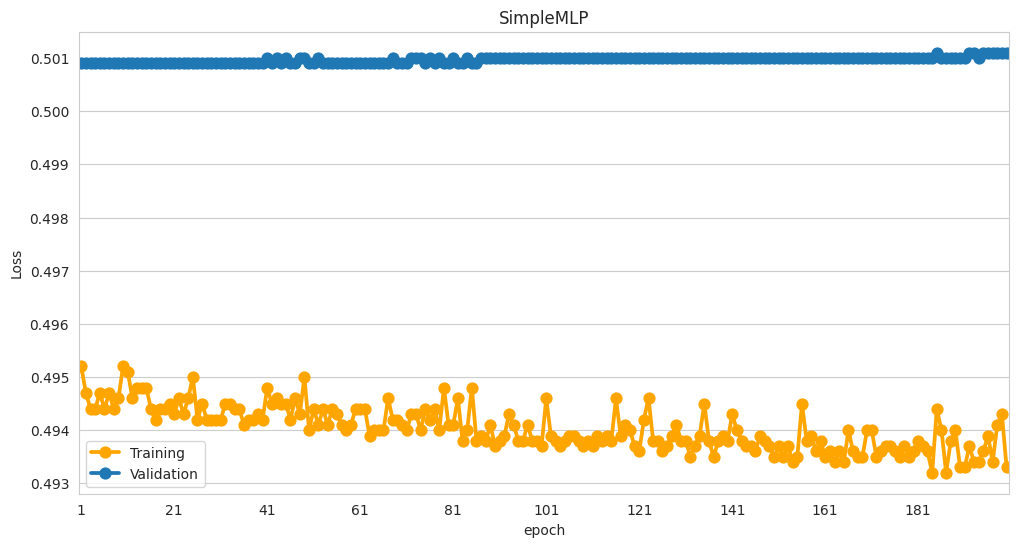

In [37]:
experiment = (best_experiment, best_performance, best_model)
plot_loss(experiment, (12, 6))

### Conclusión

Luego de ajustar los hiperparámetros a los 3 modelos planteados, nos encontramos con que el modelo que mejor ajustó fué el modelo de **arquitectura simple**, utilizando una función de activación **LeakyReLU** en las capas ocultas y un optimizador **Adagrad** con *learning rate=0.01* y *weight_decay=0*.  
Si observamos las métricas obtenidas, podemos observar que la *precisión* es de **0.49** y el score *F1* de **0.32**. Estos valores son muy bajos para un modelo de predicción, aún más si lo comparamos con los modelos que se entrenaron a lo largo del cursado de la diplomatura. Se puede pensar que las arquitecturas planteadas no ajustan correctamente a los datos, por lo que sería necesario plantear nuevas configuraciones del modelo y realizar un nuevo ajuste de hiperparámetros para mejorar las métricas, pero debido a los tiempos de cómputo que se necesitan para realizar esta tarea se plantea como trabajo a futuro.